# Natural Disasters: Revision
This is a revision of the original notebook "Natural Disasters" by Hannah.

In [1]:
import pandas as pd
import numpy as np

## Read

In [2]:
# Read
raw = pd.read_csv(
    "inputs/disasters_emdat.csv",
    encoding="latin1",
    skiprows=6,
    usecols=[
        "Year",
        "Disaster Type",
        "Country",
        "No Homeless",
        "Total Deaths",
        "No Injured",
        "No Affected",
        "No Homeless",
        "Total Affected",
        "Reconstruction Costs ('000 US$)",
        "Insured Damages ('000 US$)",
        "Total Damages ('000 US$)"
    ],
)

<AxesSubplot:xlabel='Total Deaths', ylabel="Total Damages ('000 US$)">

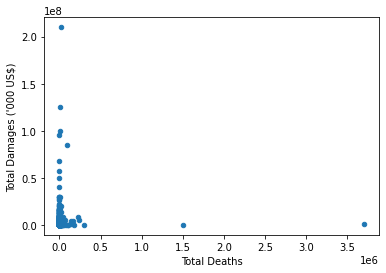

In [3]:
raw.plot(x="Total Deaths", y="Total Damages ('000 US$)", kind="scatter")

## Harmonize names

In [4]:
# Column renaming
raw = raw.rename(
    columns={
        "Disaster Type": "disaster_type",
        "Total Deaths": "deaths",
        "No Injured": "injured",
        "No Affected": "affected",
        "No Homeless": "homeless",
        "Total Affected": "total_affected",
        "Reconstruction Costs ('000 US$)": "reconstruction_costs",
        "Insured Damages ('000 US$)": "insured_damages",
        "Total Damages ('000 US$)": "total_damages",
    }
)

In [5]:
# Get metrics
combined = raw.groupby(["Year", "disaster_type", "Country"], as_index=False)[[
    "deaths", 
    "injured", 
    "affected", 
    "homeless", 
    "total_affected", 
    "reconstruction_costs", 
    "insured_damages", 
    "total_damages"
]].sum()

In [6]:
# Standardize country names
countries = pd.read_csv("inputs/countries.csv", encoding="latin1")
combined = combined.merge(countries, on="Country", how="left")
print("Countries without standardisation:", combined.loc[combined.Entity.isna(), "Country"].unique())
combined = combined.drop(columns=["Country"])

Countries without standardisation: ['Germany Fed Rep' 'Yemen Arab Rep' 'Yemen P Dem Rep' 'Germany Dem Rep']


## Processing
### Subnational to national

In [7]:
# Add subnational regions'data to their parent countries' data
subnational = pd.read_csv("inputs/subnational.csv")
map_sub = dict(zip(subnational["region"], subnational["country"]))
combined["Entity"] = combined["Entity"].replace(map_sub)
combined = combined.groupby(["Entity", "Year", "disaster_type"], as_index=False).sum()

### All disasters value

In [8]:
# Obtain all disasters figures
totals = combined.groupby(["Year", "Entity"], as_index=False).sum()
totals = totals.assign(disaster_type="All disasters")
combined = pd.concat([combined, totals])

### Supra-national entities

In [9]:
def aggregate_regions(df, mapping, column_entity, group):
    "Aggregate metrics for regions."
    df = df[-df[column_entity].isin(mapping.values())]
    df = df.replace(mapping)
    df = df.groupby(group, as_index=False).sum()
    miss = set(df[column_entity]).difference(set(mapping.values()))
    print(f"Missing: {miss}")
    df = df[df[column_entity].isin(set(mapping.values()))]
    return df

In [10]:
# Add supra-national entities (continents, income groups, world)
# Load mappings
continents_map = pd.read_csv("inputs/continent.csv")
continents_map = dict(zip(continents_map.Entity, continents_map.continent))
income_map = pd.read_csv("inputs/income.csv")
income_map = dict(zip(income_map.Entity, income_map.income_group))

In [11]:
# Create and add new entities
continents = aggregate_regions(combined, continents_map, "Entity", ["Entity", "Year", "disaster_type"])
income = aggregate_regions(combined, income_map, "Entity", ["Entity", "Year", "disaster_type"])
world = combined.groupby(["Year", "disaster_type"], as_index=False).sum().assign(Entity="World")

Missing: {'Serbia-Montenegro', 'Soviet Union'}
Missing: {'Serbia-Montenegro', 'Soviet Union', 'Yugoslavia', 'Czechoslovakia'}


In [12]:
# Merge region data
combined = pd.concat([combined, continents, income, world])

### Population

In [13]:
# Add population
population = pd.read_csv("inputs/population.csv", encoding="latin1")
# population_cont = aggregate_regions(population, continents_map, "Entity", ["Entity", "Year"])
# population_inc = aggregate_regions(population, income_map, "Entity", ["Entity", "Year"])
# population = pd.concat([population, population_cont, population_inc])
combined = combined.merge(population, on=["Entity", "Year"], how="left")

### GDP

In [14]:
# Add gdp
gdp = pd.read_csv("inputs/gdp.csv", encoding="latin1")
# gdp_cont = aggregate_regions(gdp, continents_map, "Entity", ["Entity", "Year"])
# gdp_inc = aggregate_regions(gdp, income_map, "Entity", ["Entity", "Year"])
# gdp = pd.concat([gdp, gdp_cont, gdp_inc])
combined = combined.merge(gdp, on=["Entity", "Year"], how="left")

### Rates

In [15]:
# Add rates (population)
columns = ["deaths", "injured", "affected", "homeless", "total_affected"]
combined = combined.assign(
    **{f"{col}_rate_per_100k": combined[col]/combined["Population"]*100000 for col in columns}
)
#combined = combined.drop(columns=["Population"])

In [16]:
# Add rates (gdp)
columns = ["total_damages"]
combined = combined.assign(
    **{f"{col}_pct_gdp": combined[col]/(combined["gdp"]/1000) * 100 for col in columns}
)
# combined = combined.drop(columns=["gdp"])

In [17]:
# Drop population and gdp columns
combined = combined.drop(columns=["Population", "gdp"])

### Reshape dataset

In [18]:
disasters = pd.pivot_table(combined, columns='disaster_type', index=["Year", "Entity"])
mapping = {
    "All disasters": "all_disasters",
    "Drought": "drought",
    "Earthquake": "earthquake",
    "Extreme temperature": "temperature",
    "Flood": "flood",
    "Fog": "fog",
    "Glacial lake outburst": "glacial_lake",
    "Landslide": "landslide",
    "Mass movement (dry)": "mass_movement",
    "Storm": "storm",
    "Volcanic activity": "volcanic",
    "Wildfire": "wildfire",
}
disasters.columns = [f"{colname[0]}_{mapping[colname[1]]}" for colname in disasters.columns]
disasters = disasters.reset_index()

In [19]:
disasters.head()

,Year,Entity,affected_all_disasters,affected_drought,affected_earthquake,affected_temperature,affected_flood,affected_fog,affected_glacial_lake,affected_landslide,...,total_damages_pct_gdp_all_disasters,total_damages_pct_gdp_drought,total_damages_pct_gdp_earthquake,total_damages_pct_gdp_temperature,total_damages_pct_gdp_flood,total_damages_pct_gdp_landslide,total_damages_pct_gdp_mass_movement,total_damages_pct_gdp_storm,total_damages_pct_gdp_volcanic,total_damages_pct_gdp_wildfire
0,1900,Africa,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900,Asia,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900,Cape Verde,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900,High income,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900,India,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Final processing
disasters = disasters[["Entity"] + [col for col in disasters.columns if col != "Entity"]]
disasters = disasters[disasters["Entity"].notna()]
disasters = disasters[(disasters.Year != 2021)]

### Decade dataset

In [21]:
# Decade
disasters_dec = disasters.assign(Year=disasters.Year//10*10)
disasters_dec = disasters_dec.groupby(["Entity", "Year"], as_index=False).sum()#/10
# Get average
cols = [col for col in disasters_dec.columns if col not in ["Entity", "Year"]]
disasters_dec[cols] = disasters_dec[cols]/10

In [22]:
# Add missing decades, fill nulls with zeroes
COLS_FILLNA = [x for x in disasters_dec.columns if x not in ["Entity", "Year"]]


def complete_country_decades(x):
    # Build year dataframe
    years = np.arange(x.Year.min(), x.Year.max()+1, 10)
    df_year = pd.DataFrame({"Year": years})
    # Add years to main df
    x = x.merge(df_year, how="right")
    x["Entity"] = x["Entity"].fillna(method="ffill")
    # Fill NaNs
    x[COLS_FILLNA] = x[COLS_FILLNA].fillna(0)
    return x


disasters_dec = disasters_dec.groupby("Entity", as_index=False).apply(complete_country_decades)
disasters_dec = disasters_dec.reset_index(drop=True)

## Export

In [23]:
# Export
disasters.sort_values(["Entity", "Year"]).to_csv("output/Natural disasters (EMDAT).csv", index=False)
disasters_dec.sort_values(["Entity", "Year"]).to_csv("output/Natural disasters (EMDAT – decadal).csv", index=False)